# Intro

**Transfer learning** is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

How you can use already trained neural networks to apply them in your work? I will show using this kernel as an example, using PyTorch and various Convolutional Neural Networks (CNNs), such as Alexnet, VGG, Inception etc.

Any CNN network consists of a feature extraction part (convolution layers + max pooling layers) and a classifier (fully connected layers). How CNN works your may look at kernel [How CNN works: Feature Maps visualization](https://www.kaggle.com/imcr00z/how-cnn-works-feature-maps-visualization)

There are several approaches to solving the problem:

1. Prepare the net again: describe the structure, set random weights and train - for a very long time.
2. Use an already trained network. If our datasets overlap very much, we will get a good result, otherwise, alas, we will get low accuracy.
3. CNN as a feature extraction tool. Since important commonalities are highlighted on convolutional layers, we can remove the classifier (for example, trained in 1000 classes, in the case of ImageNet) and train our own (for the number of classes we need).
4. Fine tuning. We can not only replace and train the classifier, but also refine the information at several levels of the extractor so that it better matches our dataset (as long as there is power and time). It is better not to touch the first layers, because the most frequent signs stand out there and this will take a long time.

For each network, we get a trained model and compare the loss and accuracy on [hymenoptera dataset](https://www.kaggle.com/ajayrana/hymenoptera-data):

* Using a ready-made neural network "out of the box".
* Using a neural network as a **Feature Extractor**.
* **Fine Tuning** for neural networks.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Load data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print('{} CONTAINS {} files'.format(dirname, len(filenames)))

/kaggle/input CONTAINS 0 files
/kaggle/input/hymenoptera-data CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants CONTAINS 70 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/bees CONTAINS 83 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/train CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/train/ants CONTAINS 124 files
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/train/bees CONTAINS 121 files
/kaggle/input/hymenoptera-data/hymenoptera_data/val CONTAINS 0 files
/kaggle/input/hymenoptera-data/hymenoptera_data/val/ants CONTAINS 70 files
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees CONTAINS 83 files
/kaggle

In [3]:
# define some constants

INPUT_DIR = '/kaggle/input/hymenoptera-data/hymenoptera_data/'
# Imagenet mean and standard (are calculated from all of images)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 4

We will slightly transform the input images so that the network does not learn them, but highlights common features. For this we use transforms.

In [4]:
data_tfs = {
    'train': tfs.Compose([
        tfs.Resize(300),
        tfs.RandomCrop(244),
        tfs.RandomHorizontalFlip(),
        tfs.ToTensor(),
        tfs.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': tfs.Compose([
        tfs.Resize(256),
        tfs.CenterCrop(244),
        tfs.ToTensor(),
        tfs.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}

dataset = {ds: torchvision.datasets.ImageFolder(
    root=os.path.join(INPUT_DIR, ds),
    transform=data_tfs[ds]
) for ds in ['train', 'val']}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'val']}
dataset_classes = dataset['train'].classes
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    ),
}

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


Show some images.

In [5]:
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

In [6]:
def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

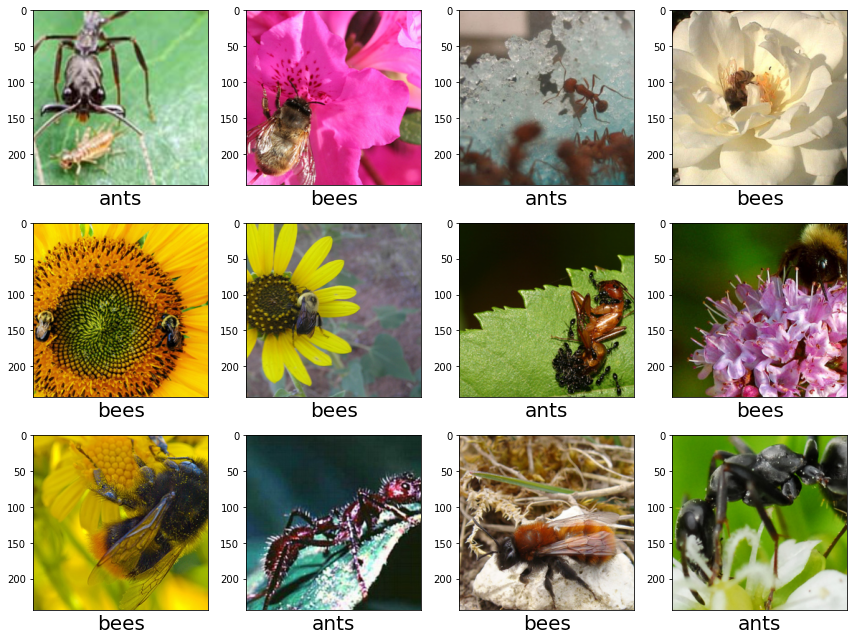

In [7]:
# show 12 images
images, classes = get_batches(dataloader['train'])
show_batches(images, classes)

In [8]:
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['val'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 25
) -> (torch.nn.Module, dict):
    r"""Training the model. Returns best model, dictionary of train and validation losses, dictionary of train and validation accuracies.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        sheduler (torch.nn.Module): Learning rate change policy
        epochs (int): Number of training iterations. Default: 25
    """
    
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_model_weights = model.state_dict()
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')
    
    for epoch in progress:
        for phase in ['train', 'val']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))
            
            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
            
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)
                
                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()
                
            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = model.state_dict()
    
    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

# AlexNet

![AlexNet](https://i.stack.imgur.com/DIQWD.png)

AlexNet is the name of a convolutional neural network architecture, designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton.

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. 

[The original paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [10]:
model = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [11]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Look, in_features for the classifier is 9216. We have to do the same.

## Retrain

In [12]:
num_in_features = 9216
num_out_features = 2

model.classifier = torch.nn.Linear(num_in_features, num_out_features)
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

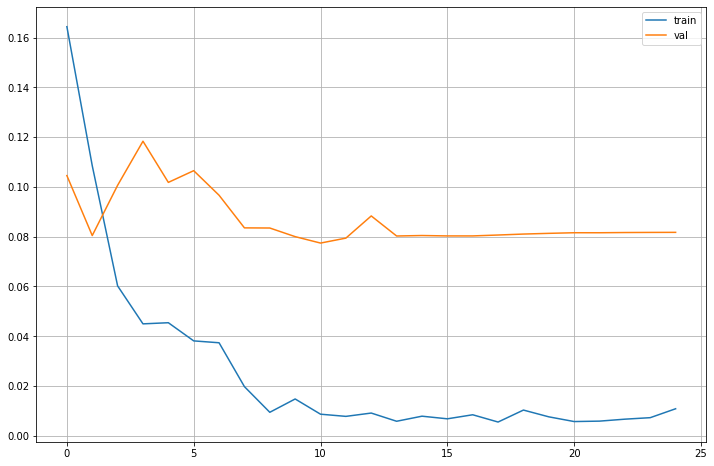

In [13]:
show_metrics(losses)

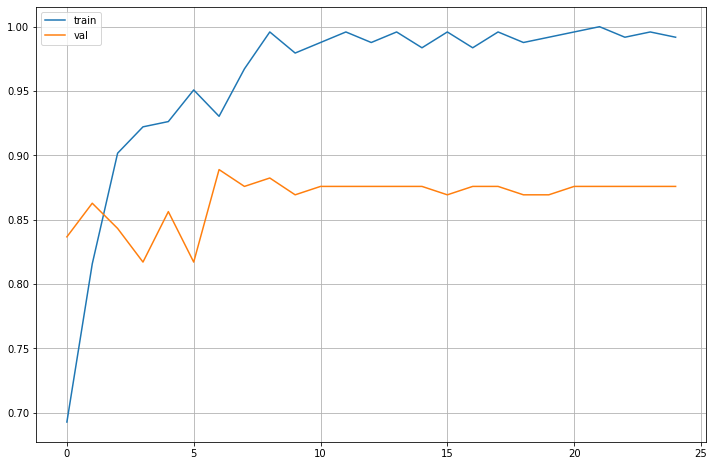

In [14]:
show_metrics(accuracies)

In [15]:
max(accuracies['val'])

tensor(0.8889, device='cuda:0')

## Net as Feature Extractor

1. freeze Feature Extractor so that no backpropagation is applied to them
2. replace the classifier

In [16]:
model = torchvision.models.alexnet(pretrained=True)

In [17]:
# by default, all layers of the neural network are retrained
for name, param in model.named_parameters():
    print(f'{name:30}{param.requires_grad}')

features.0.weight             True
features.0.bias               True
features.3.weight             True
features.3.bias               True
features.6.weight             True
features.6.bias               True
features.8.weight             True
features.8.bias               True
features.10.weight            True
features.10.bias              True
classifier.1.weight           True
classifier.1.bias             True
classifier.4.weight           True
classifier.4.bias             True
classifier.6.weight           True
classifier.6.bias             True


In [18]:
for param in model.parameters():
    param.requires_grad = False
model.classifier = torch.nn.Linear(num_in_features, num_out_features)
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

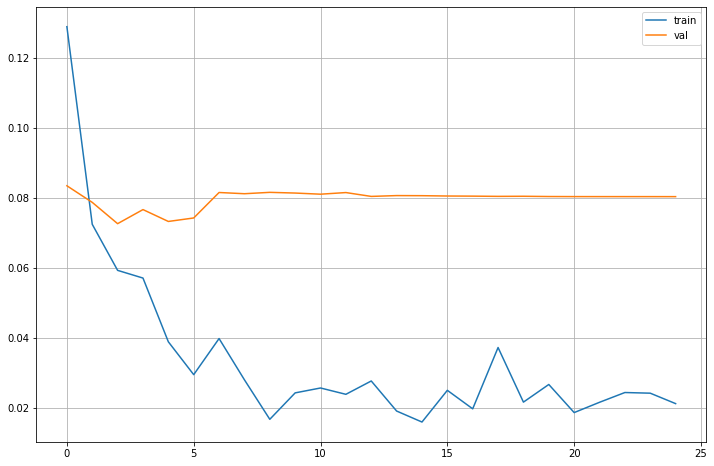

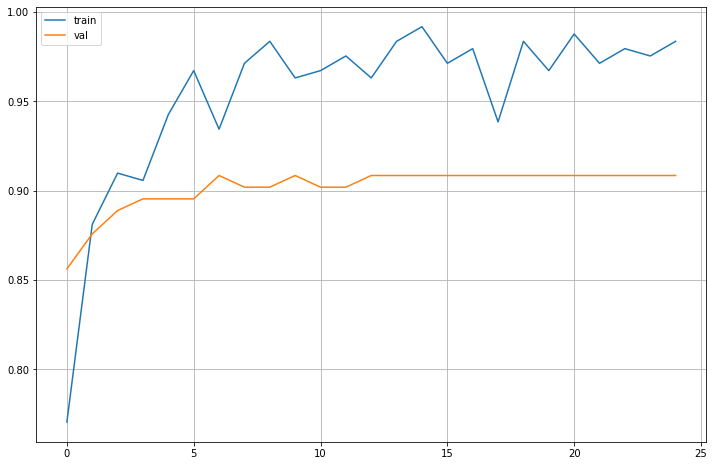

tensor(0.9085, device='cuda:0')

In [19]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])

## Fine Tuning

In [20]:
model = torchvision.models.alexnet(pretrained=True)

In [21]:
layers_to_freeze = 6
for i, (name, param) in enumerate(model.features.named_parameters()):
    if i < layers_to_freeze:
        param.requires_grad = False
    print(f'{name:30}{param.requires_grad}')
model.classifier = torch.nn.Linear(num_in_features, num_out_features)
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
retrain_layers = list(model.features.parameters())[layers_to_freeze:] + list(model.classifier.parameters())
optimizer = torch.optim.Adam(retrain_layers, lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

0.weight                      False
0.bias                        False
3.weight                      False
3.bias                        False
6.weight                      False
6.bias                        False
8.weight                      True
8.bias                        True
10.weight                     True
10.bias                       True


Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

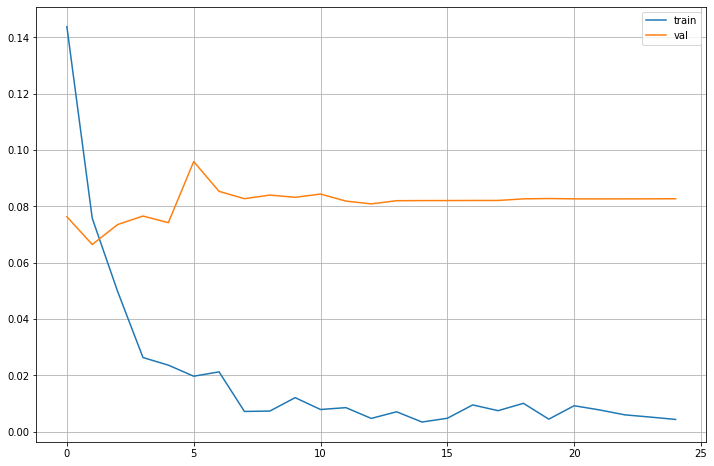

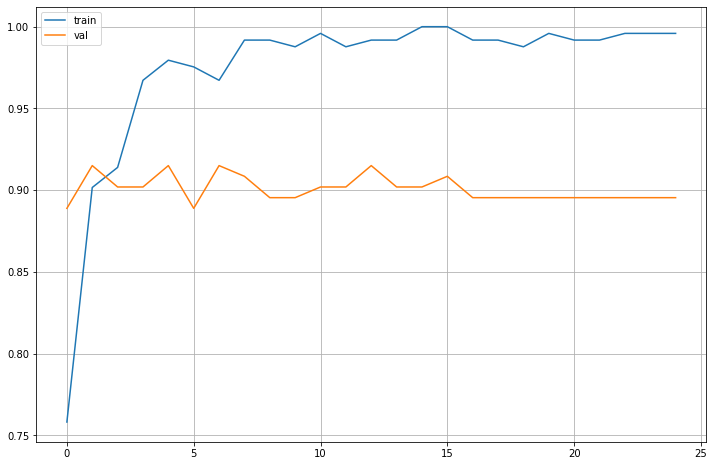

tensor(0.9150, device='cuda:0')

In [22]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])

## Tune optimizer

We can not freeze the layers, but make them smaller learning rate.

In [23]:
model = torchvision.models.alexnet(pretrained=True)

In [24]:
model.classifier = torch.nn.Linear(num_in_features, num_out_features)
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer_params = [
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters()},
]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

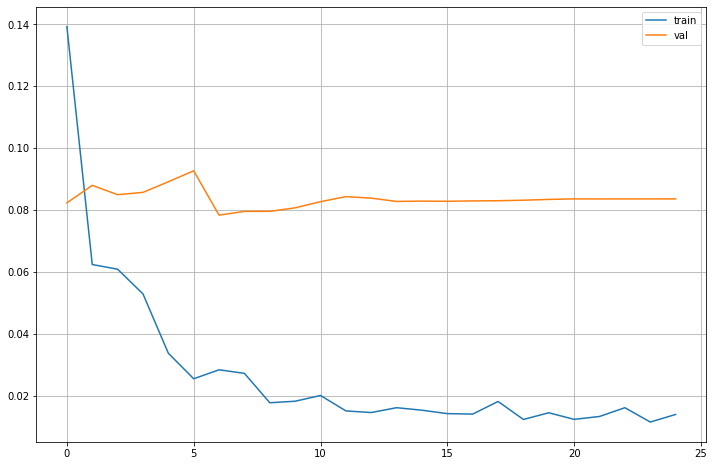

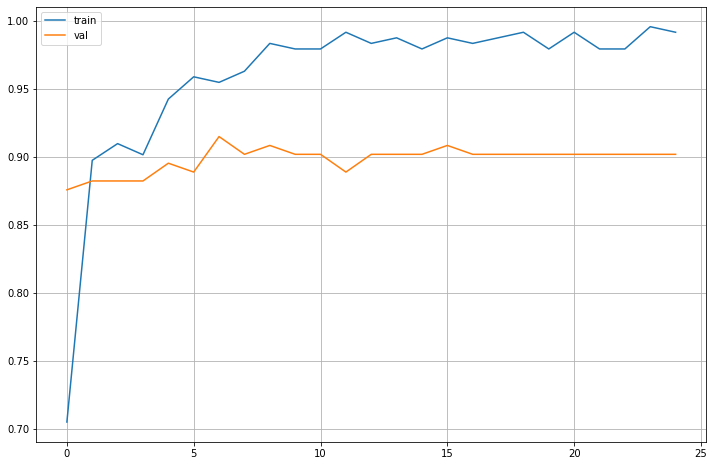

tensor(0.9150, device='cuda:0')

In [25]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])

Using the writing learning loop and visualization features, you can explore more modern networks on your own. I'll leave some gaps for you to experiment with.
If you want me to finish the article, write me in the comments.
+1 notepad if you like it.

Links:

* [TORCHVISION.MODELS](https://pytorch.org/vision/stable/models.html)

# VGGNet

[Review: VGGNet — 1st Runner-Up (Image Classification), Winner (Localization) in ILSVRC 2014](https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11)

In [26]:
model_vgg16 = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [27]:
# model_vgg16

## Inception v.3

[A Simple Guide to the Versions of the Inception Network](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

NB! Reinitialize dataloaders to 299 x 299 size.

In [28]:
model_incept = torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [29]:
# model_incept

In [30]:
model_incept.AuxLogits.fc = torch.nn.Linear(768, 2)
model_incept.fc = torch.nn.Linear(2048, 2)
model_incept.aux_logits = False

# Resnet

In [31]:
model_resnet50 = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [32]:
#model_resnet50

# ResNeXt

* [A Tutorial on Filter Groups (Grouped Convolution)](https://blog.yani.ai/filter-group-tutorial/)
* [Original paper](https://arxiv.org/pdf/1611.05431.pdf)

# Efficient Net

[EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

In [33]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=109bcd845a68b2a93b0fc48d45eaa12934a7c517e8d6e5aae21d6dbb32a5fbb7
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [34]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


See you later!